In [1]:
# Network/data is small enough that running on GPU slows training down
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

- Player ID map
https://www.smartfantasybaseball.com/tools/

- stats
http://www.seanlahman.com/baseball-archive/statistics/

# Load statcast data

In [2]:
import pandas as pd

df = pd.read_csv('./statcast-2019-05-18.csv')
df.shape

/home/dante/venvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(698334, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(572572, 90)

In [4]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
0,94.0,5.0,LAA,-11.3601,25.1390,-31.7129,1.0,2.0,5.0,543760.0,line_drive,NaN,NaN,Marcus Semien singles on a line drive to right...,hit_into_play_score,82.497,NaN,0.213,0.207,single,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,133.98,82.73,278.0,9.0,5.0,OAK,Strategic,11.0,Bot,0.0,25.0,82.1,3.0,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9585,0.0858,Changeup,6.0,CH,598287.0,598287.0,1.0147,2.5574,Noe Ramirez,5.0,5.0,5.0,5.0,5.991,-2.6238,54.5068,5.0668,83.5,2202.0,NaN,NaN,R,2.0,180330_000927,1.3048,3.0286,NaN,NaN,X,NaN,10.1373,-121.0093,0.5756,1.0,0.9,12.0
1,94.0,5.0,LAA,-10.9769,23.0148,-32.6285,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,82.405,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,9.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,-17.0,75.1,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9663,0.0005,Changeup,5.0,CH,598287.0,598287.0,0.4161,2.7585,Noe Ramirez,5.0,5.0,5.0,5.0,6.174,-2.6167,54.3240,5.0671,82.7,2035.0,NaN,NaN,R,2.0,180330_000833,1.3010,3.0452,NaN,NaN,S,NaN,8.7471,-120.1073,1.2442,NaN,NaN,3.0
2,94.0,5.0,LAA,7.1848,23.4589,-32.9895,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,75.252,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,254.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,27.0,80.3,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.9971,-0.0254,Curveball,4.0,CU,598287.0,598287.0,-0.1869,2.1676,Noe Ramirez,5.0,5.0,5.0,5.0,5.360,-2.9329,55.1378,4.8254,77.2,2875.0,NaN,NaN,R,1.0,180330_000804,1.3010,3.0452,NaN,NaN,S,NaN,4.0109,-112.0582,1.4503,NaN,NaN,5.0
3,94.0,5.0,LAA,2.7950,23.1420,-33.8923,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,74.808,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.5234,-0.1545,Curveball,3.0,CU,598287.0,598287.0,0.7067,1.7718,Noe Ramirez,5.0,5.0,5.0,5.0,5.545,-2.8895,54.9534,4.8506,76.6,2722.0,NaN,NaN,R,0.0,180330_000729,1.3010,3.0452,NaN,NaN,S,NaN,6.5573,-111.0574,0.9231,NaN,NaN,9.0
4,94.0,5.0,LAA,6.9345,23.0959,-31.9858,NaN,1.0,5.0,543760.0,NaN,NaN,NaN,NaN,ball,76.087,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,1.0697,0.1136,Curveball,2.0,CU,598287.0,598287.0,2.3848,2.7632,Noe Ramirez,5.0,5.0,5.0,5.0,5.563,-2.8185,54.9349,4.8878,77.8,2880.0,NaN,NaN,R,0.0,180330_000704,1.6456,3.4918,NaN,NaN,B,NaN,9.0882,-112.7488,2.2400,NaN,NaN,12.0


In [5]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(572572, 90)

## Remove at-bats due to fielding influence

In [6]:
invalid_events = {
    'catcher_interf',
    'fielders_choice_out',
    'field_error',
    'fielders_choice',
    'batter_interference',
}
invalid_at_bats = df.loc[:, ['game_pk', 'at_bat_number', 'events']]
invalid_at_bats['remove'] = invalid_at_bats.events.isin(invalid_events)
invalid_at_bats = invalid_at_bats.groupby(['game_pk', 'at_bat_number']).remove.max()

In [7]:
invalid_at_bats.sum()

1628

In [8]:
invalid_at_bats = pd.DataFrame(invalid_at_bats[~invalid_at_bats])
df = df.merge(invalid_at_bats, left_on=invalid_at_bats.index.names, right_index=True)
df.shape

(566962, 91)

# Load player IDs

In [9]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [10]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [11]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'IDPLAYER']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [12]:
batter_ids = batter_ids[~batter_ids.batter_mlbid.isnull()]
pitcher_ids = pitcher_ids[~pitcher_ids.pitcher_mlbid.isnull()]

In [13]:
assert len(batter_ids) == batter_ids.batter_mlbid.nunique(), f'{len(batter_ids)} != {batter_ids.batter_mlbid.nunique()}'

In [14]:
assert len(pitcher_ids) == pitcher_ids.pitcher_mlbid.nunique(), f'{len(pitcher_ids)} != {pitcher_ids.pitcher_mlbid.nunique()}'

## Blend IDs in with statcast data

In [15]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(566962, 97)

In [16]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,remove,batter_mlbid,batter_mlbname,batter_idplayer,pitcher_mlbid,pitcher_mlbname,pitcher_idplayer
531529,20.0,0.0,TB,8.2393,31.3785,-8.4610,NaN,0.0,0.0,641505.0,NaN,NaN,NaN,NaN,called_strike,97.473,NaN,NaN,NaN,NaN,491696.0,491696.0,641343.0,664040.0,622110.0,621563.0,502054.0,595281.0,605480.0,0.0,2018-09-23,531742.0,R,2018.0,NaN,NaN,NaN,NaN,0.0,TOR,Standard,3.0,Bot,NaN,NaN,NaN,NaN,Strategic,620446.0,NaN,NaN,2.0,L,0.5057,1.5978,4-Seam Fastball,1.0,FF,605483.0,605483.0,-0.1537,1.8609,Blake Snell,0.0,0.0,0.0,0.0,6.876,1.7951,53.6240,6.5661,96.6,2469.0,NaN,NaN,R,0.0,180923_174503,1.5289,3.2669,NaN,NaN,S,NaN,-6.4202,-140.2680,-10.7498,NaN,NaN,8.0,False,NaN,NaN,NaN,605483.0,Blake Snell,snellbl01
325863,59.0,2.0,MIL,-3.7969,29.4503,-14.6732,NaN,0.0,0.0,621550.0,NaN,NaN,NaN,NaN,ball,96.268,NaN,NaN,NaN,NaN,456124.0,456124.0,542583.0,570731.0,519058.0,606115.0,460075.0,456715.0,592885.0,2.0,2018-08-19,531274.0,R,2018.0,NaN,NaN,NaN,NaN,0.0,STL,Standard,8.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,R,-0.2418,1.3030,4-Seam Fastball,1.0,FF,502026.0,502026.0,-0.0832,4.0620,Jeremy Jeffress,2.0,0.0,2.0,0.0,6.210,-0.9940,54.2883,6.1243,96.0,2309.0,NaN,NaN,R,0.0,180819_204538,1.6939,3.5385,NaN,NaN,B,NaN,2.9536,-139.9031,-2.8433,NaN,NaN,11.0,False,NaN,NaN,NaN,502026.0,Jeremy Jeffress,jeffrje01
86172,36.0,3.0,WSH,12.8747,23.0804,-23.1582,0.0,1.0,0.0,621512.0,ground_ball,NaN,NaN,"Tomas Nido grounds into a force out, shortstop...",hit_into_play,81.970,NaN,0.055,0.048,force_out,600474.0,600474.0,475582.0,435062.0,594694.0,607208.0,501213.0,572191.0,547180.0,3.0,2018-04-17,529668.0,R,2018.0,110.32,156.28,8.0,6.0,0.0,NYM,Standard,4.0,Bot,0.0,-11.0,76.6,2.0,Standard,501571.0,NaN,NaN,2.0,L,1.2496,0.8915,Changeup,3.0,CH,461829.0,461829.0,0.9531,1.4849,Gio Gonzalez,3.0,0.0,3.0,0.0,5.990,2.1293,54.5099,5.3374,82.5,1678.0,NaN,NaN,R,1.0,180418_003213,1.1563,2.9924,NaN,NaN,X,NaN,-5.0356,-119.9042,-3.9216,1.0,0.0,14.0,False,NaN,NaN,NaN,461829.0,Gio Gonzalez,gonzagi01
540797,55.0,3.0,TOR,3.2099,22.1855,-37.0746,0.0,0.0,3.0,620446.0,ground_ball,NaN,NaN,Richard Urena grounds out to first baseman Jak...,hit_into_play,79.679,NaN,0.458,0.436,field_out,446192.0,446192.0,641343.0,664040.0,621563.0,642715.0,502054.0,605480.0,640457.0,5.0,2018-09-30,531836.0,R,2018.0,153.50,164.75,53.0,3.0,5.0,TB,Standard,7.0,Top,0.0,2.0,93.9,4.0,Standard,NaN,NaN,NaN,0.0,R,0.3681,-0.5772,Curveball,3.0,CU,643493.0,643493.0,0.3023,1.1797,Austin Pruitt,3.0,3.0,5.0,5.0,4.859,-0.2601,55.6395,5.9875,81.7,2809.0,NaN,NaN,L,2.0,180930_211857,1.6538,3.2859,NaN,NaN,X,NaN,0.5813,-118.8230,-3.1462,1.0,0.0,14.0,False,NaN,NaN,NaN,643493.0,Austin Pruitt,pruitau01
505342,37.0,5.0,LAD,1.9586,28.5526,-10.1501,NaN,0.0,3.0,605244.0,NaN,NaN,NaN,NaN,called_strike,90.001,NaN,NaN,NaN,NaN,518735.0,518735.0,571970.0,571771.0,457759.0,592518.0,592626.0,641355.0,624577.0,5.0,2018-09-29,531814.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,SF,Standard,4.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,L,0.1135,1.8172,4-Seam Fastball,1.0,FF,477132.0,47

# Load statistics

## Batting

In [17]:
batting_stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
batting_stats = batting_stats.merge(batter_ids, left_on='playerID', right_on='batter_idplayer')
batting_stats = batting_stats[batting_stats.yearID == 2018]
batting_stats.shape

(1205, 25)

In [18]:
# players are represented multiple times when there is a trade
batting_stats = batting_stats.groupby('batter_mlbid', as_index=False)[[
    'H', 'BB', 'HBP', '2B', '3B', 'HR', 'SF', 'AB'
]].sum()
batting_stats['1B'] = batting_stats.H - (batting_stats['2B'] - batting_stats['3B'] - batting_stats['HR'])
batting_stats.shape

(1071, 10)

In [19]:
stats = batting_stats  # alias
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    823.000000
 mean       0.244371
 std        0.144940
 min        0.000000
 25%        0.161528
 50%        0.285714
 75%        0.330852
 max        1.000000
 Name: obp, dtype: float64, count    823.000000
 mean       0.345414
 std        0.246788
 min        0.000000
 25%        0.125000
 50%        0.388889
 75%        0.504371
 max        2.000000
 Name: slg, dtype: float64, count    823.000000
 mean       0.589784
 std        0.373841
 min        0.000000
 25%        0.312091
 50%        0.684118
 75%        0.835459
 max        3.000000
 Name: ops, dtype: float64)

## Pitching

In [20]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(pitcher_ids, left_on='playerID', right_on='pitcher_idplayer')
pitching_stats.shape

(657, 33)

In [21]:
pitching_stats['IP'] = pitching_stats.IPouts / 3

In [22]:
pitching_stats = pitching_stats.groupby([
    'pitcher_mlbid',
], as_index=False)[['IP', 'BB', 'H', 'ER']].sum()
pitching_stats.shape

(581, 5)

In [23]:
pitching_stats['ERA'] = ((pitching_stats.ER / pitching_stats.IP) * 9 )
pitching_stats['WHIP'] = (pitching_stats.BB + pitching_stats.H) / pitching_stats.IP

# Feature engineering

## Create target variable

Did the at-bat result in a hit or walk?

In [24]:
df.events.unique()

array(['single', nan, 'triple', 'strikeout', 'field_out', 'double',
       'walk', 'grounded_into_double_play', 'home_run', 'hit_by_pitch',
       'sac_bunt', 'pickoff_caught_stealing_2b', 'caught_stealing_2b',
       'force_out', 'double_play', 'sac_fly', 'other_out', 'pickoff_1b',
       'strikeout_double_play', 'caught_stealing_3b', 'pickoff_2b',
       'triple_play', 'sac_bunt_double_play', 'caught_stealing_home',
       'sac_fly_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_home', 'pickoff_caught_stealing_3b',
       'run'], dtype=object)

In [25]:
import numpy as np
target_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]
target_events = {event: i for i, event in enumerate(target_events, start=1)}
df['target'] = df.events.map(target_events).fillna(0).astype(int)

## Create auxillary targets

In [26]:
auxillary_targets = [
    'hit_distance_sc',
    'launch_speed',
    'launch_angle',
]
for t in auxillary_targets:
    df[t] = (df[t] - df[t].mean()) / df[t].std()
df['auxillary_targets'] = df[auxillary_targets].fillna(0).values.tolist()

In [27]:
import numpy as np
np.stack(df.iloc[:10]['auxillary_targets'])

array([[ 0.94858298, -0.0637947 ,  0.29688873],
       [-1.26468766, -0.53543634, -1.15239467],
       [ 0.75111645, -0.18507398,  0.36590222],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.55743809,  0.5762904 ,  0.19336848],
       [ 0.42200558, -0.62302694,  1.26307766],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

# Who's on first

Or rather, is anyone on first.

In [28]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [29]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

# How many pitches has the pitcher thrown

In [30]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
3965,529406.0,1.0,1.0,502042.0,1,1
3944,529406.0,2.0,1.0,502042.0,1,2
3943,529406.0,2.0,2.0,502042.0,1,3
3942,529406.0,2.0,3.0,502042.0,1,4
3843,529406.0,3.0,1.0,502042.0,1,5
3842,529406.0,3.0,2.0,502042.0,1,6
3841,529406.0,3.0,3.0,502042.0,1,7
3840,529406.0,3.0,4.0,502042.0,1,8
3839,529406.0,3.0,5.0,502042.0,1,9
3838,529406.0,3.0,6.0,502042.0,1,10


In [31]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

# Create batter IDs to be embedded

In [32]:
import numpy as np
eligible_batters = batting_stats[batting_stats.AB > 100].batter_mlbid
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [33]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(820, 2)

## Create pitcher IDs to be embedded

In [34]:
eligible_pitchers = pitching_stats[pitching_stats.IP > 20].pitcher_mlbid
df['pitcher_id'] = np.where(df.pitcher.isin(eligible_pitchers), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(451, 452)

# Define features

In [35]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number',
    'ax',
    'ay',
    'az',
    'pfx_x',
    'pfx_z',
    'vx0',
    'vy0',
    'vz0',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_y',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team',
    'p_throws',
]

target = 'target'

# Define an encoder

To map IDs to valid range for `keras` embedding layers

In [36]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

# Recurrent model

## Build batches for training

In [37]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [38]:
if False:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [39]:
df_sample.shape

(566962, 106)

Here we "featurize" each at-bat. In the following step we sort each at-bat by the number of pitches thrown and build the batches based on these groups so that we minimize padding during training.

In [40]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)
np.random.shuffle(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    
    y = np.zeros((len(target_events) + 1,))
    assert len(group_df.target.unique()) <= 2
    y[group_df.target.max()] = 1
    
    y_aux = np.stack(group_df['auxillary_targets'])
    return x, y, y_aux, len(x['numeric_inputs'])

In [41]:
import multiprocessing as mp
import numpy as np

# this takes ridiculously long if not parallelized
pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, y_aux_train, batch_lens = zip(*res)

In [42]:
len(X_train), len(y_train), len(y_aux_train)

(144994, 144994, 144994)

## Create a list of the batches

In [43]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 at-bats
batch_ids = np.cumsum(batch_lens) // (4 * 32)
len(batch_ids), len(set(batch_ids))

(144994, 4430)

In [44]:
batch_ids[:1000:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [45]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))

In [46]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = [
    f'{f}_input' for f in categorical_features
] + ['numeric_inputs']

def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys, ys_aux = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        y = np.array(ys)
        y_aux = np.array(ys_aux)
        yield X_batch, y, y_aux
        

Using TensorFlow backend.


In [47]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [48]:
len(batches)

4430

In [49]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape, batches[0][2].shape

((127, 1, 25), (127, 6), (127, 1, 3))

In [50]:
batches[-1][0]['numeric_inputs'].shape, batches[-1][1].shape, batches[-1][2].shape

((3, 21, 25), (3, 6), (3,))

In [51]:
i_range = iter(range(len(batches)))

In [52]:
i = next(i_range)
batches[i][0]['numeric_inputs'].shape, batches[i][1].shape, batches[i][2].shape

((127, 1, 25), (127, 6), (127, 1, 3))

## build model

In [106]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 4,
    'pitcher_id': 1,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
])
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='y')(X)


X_aux = keras.layers.Dense(32, activation='relu')(X_lstm)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(32, activation='relu')(X_aux)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(len(auxillary_targets), name='y_aux')(X_aux)

model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=[X, X_aux])

In [107]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [108]:
model.compile(loss={'y': 'categorical_crossentropy', 'y_aux': 'mse'}, optimizer='adam', loss_weights={'y': 1., 'y_aux': 3.})

In [109]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, {'y': y, 'y_aux': y_aux}
model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/10
4430/4430 [==============================] - 44s 10ms/step - loss: 1.7920 - y_loss: 0.9212 - y_aux_loss: 0.2903
Epoch 2/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.5441 - y_loss: 0.7660 - y_aux_loss: 0.2594
Epoch 3/10
4430/4430 [==============================] - 41s 9ms/step - loss: 1.5215 - y_loss: 0.7501 - y_aux_loss: 0.2572
Epoch 4/10
4430/4430 [==============================] - 41s 9ms/step - loss: 1.5057 - y_loss: 0.7394 - y_aux_loss: 0.2554
Epoch 5/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.4950 - y_loss: 0.7323 - y_aux_loss: 0.2542
Epoch 6/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.4912 - y_loss: 0.7293 - y_aux_loss: 0.2540
Epoch 7/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.4829 - y_loss: 0.7262 - y_aux_loss: 0.2522
Epoch 8/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.4799 - y_loss: 0.7237 - y_aux_loss: 0.2521
Epoch 9/10
4430/4430 [=

In [110]:
len(L)

141

## P/R curves

In [111]:
preds = np.concatenate([model.predict(x)[0] for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

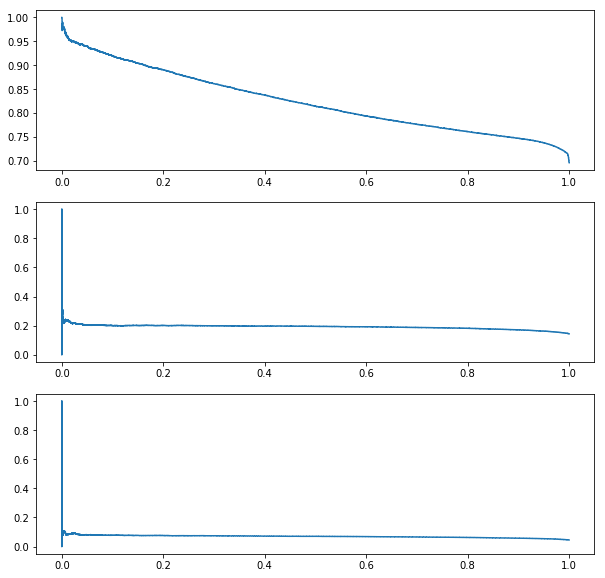

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for idx, ax in enumerate(axs):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    ax.plot(r, p)


# Inspect model

## Defining utility functions

In [113]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

## Look at batter embeddings

In [114]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', model)

from sklearn.manifold import TSNE
batters['x'], batters['y'] = zip(*TSNE(2).fit_transform(batter_embeddings.reshape((-1, 4))))
#batters['x'], batters['y'] = zip(*batter_embeddings.reshape((-1, 2)))

In [115]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

In [116]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'slg'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [117]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [118]:
pitcher_weights = model.get_layer('y').get_weights()[0][-6:-4, :]
batter_weights = model.get_layer('y').get_weights()[0][-4:, :]

In [119]:
target_events

{'single': 1, 'double': 2, 'triple': 3, 'home_run': 4, 'walk': 5}

In [120]:
batters['prob_on_base'] = np.dot(batter_embeddings.reshape((-1, 4)), batter_weights)[:, 1:].sum(axis=1)  # this is contribution of prob of on-base

In [121]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'prob_on_base'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            prob_on_base=batters.prob_on_base
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [122]:
batters.sort_values('prob_on_base', ascending=False).head(10)

,batter_id,batter_mlbname,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,x,y,prob_on_base
413,642423.0,Magnueris Sierra,642423.0,28,6,0.0,3,0,0,0.0,147,25,0.222222,0.210884,0.433107,19.906061,-7.173053,1.392743
95,592261.0,Delino DeShields,592261.0,72,43,3.0,14,1,2,1.0,334,61,0.309711,0.299401,0.609112,11.359761,14.423198,1.317072
356,543776.0,J.B. Shuck,543776.0,25,10,1.0,3,1,0,0.0,130,23,0.255319,0.246154,0.501473,12.350451,-2.466724,1.249201
297,605480.0,Mallex Smith,605480.0,142,47,8.0,27,10,2,2.0,480,127,0.366853,0.456250,0.823103,23.676619,-0.923045,1.231130
272,571740.0,Billy Hamilton,571740.0,119,46,1.0,16,9,4,4.0,504,116,0.299099,0.378968,0.678067,-1.715018,-3.638747,1.212176
405,664058.0,David Fletcher,664058.0,78,15,3.0,18,2,1,2.0,284,63,0.315789,0.383803,0.699592,-2.589696,-5.875834,1.138795
302,547172.0,Tony Wolters,547172.0,31,26,6.0,4,4,3,2.0,182,34,0.291667,0.362637,0.654304,6.909065,-9.429789,1.075445
355,605508.0,Charles Tilson,605508.0,28,10,1.0,1,1,0,1.0,106,28,0.330508,0.311321,0.641829,21.281736,-5.317613,1.017098
299,572365.0,Ryan Goins,572365.0,26,4,0.0,8,1,0,0.0,115,19,0.252101,0.330435,0.582536,12.795810,-5.109823,0.960793
350,643396.0,Isiah Kiner-Falefa,643396.0,93,28,6.0,18,2,4,1.0,356,81,0.324808,0.390449,0.715258,12.878572,-3.526558,0.960477


## look at pitchers

In [123]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', model)
pitchers['prob_not_on_base'] = pitcher_embeddings.reshape(-1)
pitchers.sort_values('prob_not_on_base')

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
42,600917.0,Jose Leclerc,600917.0,57.666667,25,24,10,1.560694,0.849711,-0.843085
345,543507.0,Trevor May,543507.0,25.333333,5,21,9,3.197368,1.026316,-0.792331
38,493603.0,Adam Ottavino,493603.0,77.666667,36,41,21,2.433476,0.991416,-0.791960
83,476454.0,Dellin Betances,476454.0,66.666667,26,44,20,2.700000,1.050000,-0.754834
414,650895.0,Diego Castillo,650895.0,56.666667,18,36,20,3.176471,0.952941,-0.752401
60,489446.0,Kirby Yates,489446.0,63.000000,17,41,15,2.142857,0.920635,-0.746387
197,451584.0,Wade Davis,451584.0,65.333333,26,43,30,4.132653,1.056122,-0.744227
406,424144.0,Oliver Perez,424144.0,32.333333,7,17,5,1.391753,0.742268,-0.732151
11,467008.0,Pedro Strop,467008.0,59.666667,21,38,15,2.262570,0.988827,-0.731816
30,621242.0,Edwin Diaz,621242.0,73.333333,17,41,16,1.963636,0.790909,-0.711198


In [135]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', model)
# pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))
pitchers['embedding'] = pitcher_embeddings.reshape(-1)
pitchers.sort_values('embedding').head(20)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,embedding
42,600917.0,Jose Leclerc,600917.0,57.666667,25,24,10,1.560694,0.849711,-0.843085
345,543507.0,Trevor May,543507.0,25.333333,5,21,9,3.197368,1.026316,-0.792331
38,493603.0,Adam Ottavino,493603.0,77.666667,36,41,21,2.433476,0.991416,-0.791960
83,476454.0,Dellin Betances,476454.0,66.666667,26,44,20,2.700000,1.050000,-0.754834
414,650895.0,Diego Castillo,650895.0,56.666667,18,36,20,3.176471,0.952941,-0.752401
60,489446.0,Kirby Yates,489446.0,63.000000,17,41,15,2.142857,0.920635,-0.746387
197,451584.0,Wade Davis,451584.0,65.333333,26,43,30,4.132653,1.056122,-0.744227
406,424144.0,Oliver Perez,424144.0,32.333333,7,17,5,1.391753,0.742268,-0.732151
11,467008.0,Pedro Strop,467008.0,59.666667,21,38,15,2.262570,0.988827,-0.731816
30,621242.0,Edwin Diaz,621242.0,73.333333,17,41,16,1.963636,0.790909,-0.711198


In [137]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', model)
# pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))
pitchers['embedding'] = pitcher_embeddings.reshape(-1)
pitchers[pitchers.IP > 100].sort_values('embedding').head(20)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,embedding
320,621111.0,Walker Buehler,621111.0,137.333333,37,95,40,2.621359,0.961165,-0.652134
230,594798.0,Jacob deGrom,594798.0,217.000000,46,152,41,1.700461,0.912442,-0.638740
399,605397.0,Joe Musgrove,605397.0,115.333333,23,113,52,4.057803,1.179191,-0.614251
129,605483.0,Blake Snell,605483.0,180.666667,64,112,38,1.892989,0.974170,-0.538153
419,607074.0,Carlos Rodon,607074.0,120.666667,55,97,56,4.176796,1.259669,-0.504947
296,434671.0,Anibal Sanchez,434671.0,136.666667,42,106,43,2.831707,1.082927,-0.504020
130,456034.0,David Price,456034.0,176.000000,50,151,70,3.579545,1.142045,-0.483908
294,656794.0,Sean Newcomb,656794.0,164.000000,81,137,71,3.896341,1.329268,-0.482802
338,554430.0,Zack Wheeler,554430.0,182.333333,55,150,67,3.307130,1.124314,-0.460238
309,607625.0,Seth Lugo,607625.0,101.333333,28,81,30,2.664474,1.075658,-0.447486


In [ ]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat =  'WHIP'

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            WHIP=pitchers.WHIP
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256[::-1], low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

In [ ]:
pitchers['prob_not_on_base'] = np.dot(pitchers[['x', 'y']].values, pitcher_weights)[:, 0]

In [ ]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = 'prob_not_on_base'

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            prob_not_on_base=pitchers.prob_not_on_base
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

In [ ]:
pitchers.sort_values('prob_not_on_base', ascending=False).head(10)

## Look at attention

In [126]:
A = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [127]:
batch_idx = 1
bx, by, _ = batches[batch_idx]
aa = np.squeeze(A.predict(bx))
bx['numeric_inputs'].shape, aa.shape

((21, 6, 25), (21, 6))

In [128]:
aa

array([[9.0429621e-06, 5.8851197e-06, 4.3559503e-06, 7.8747926e-06,
        3.3732885e-04, 9.9963546e-01],
       [6.6265571e-08, 3.9400131e-08, 4.7577601e-08, 6.6528983e-08,
        7.1111128e-07, 9.9999905e-01],
       [1.5158787e-06, 1.4018210e-06, 1.2797158e-06, 1.2547891e-06,
        1.3573277e-04, 9.9985874e-01],
       [5.6214129e-05, 5.8738497e-05, 6.1949933e-05, 1.3107424e-04,
        4.8304646e-04, 9.9920899e-01],
       [1.2931204e-07, 1.3330340e-07, 1.1987557e-07, 1.6175927e-07,
        5.5249512e-07, 9.9999893e-01],
       [6.3156094e-08, 5.3775697e-08, 4.9744543e-08, 4.0833605e-08,
        8.7133180e-03, 9.9128646e-01],
       [6.8861329e-05, 6.5580105e-05, 4.3490811e-05, 9.8083889e-05,
        4.7142133e-03, 9.9500978e-01],
       [4.0595623e-07, 4.2522311e-07, 4.1042745e-07, 6.0510780e-07,
        3.4060517e-06, 9.9999475e-01],
       [4.7055810e-08, 2.6733822e-08, 3.1026921e-08, 4.1802764e-08,
        2.6724965e-07, 9.9999964e-01],
       [4.9347847e-08, 2.9656793e-08,

In [129]:
np.argmax(aa, axis=1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [130]:
p = model.predict(bx)

In [131]:
inverse_target_map = {v: k for k, v in target_events.items()}
def inverse_transform(X):
    d = pd.DataFrame(X['numeric_inputs'], columns=numeric_features)
    for f in categorical_features:
        d[f] = encoder.inverse_transform(pd.Series(X[f'{f}_input']), f)
    return d

In [132]:
bx

{'if_fielding_alignment_input': array([[2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 1, 1, 1],
        [0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 0],
        [2, 2, 2, 2, 2, 2]], dtype=int32),
 'of_fielding_alignment_input': array([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],

In [133]:
idx = 0
d = inverse_transform({k: v[idx] for k, v in bx.items()})
d['attention'] = aa[idx].reshape(-1)
d = d.merge(batters[['batter_id', 'batter_mlbname']])
d = d.merge(pitchers[['pitcher_id', 'player_name']])

print('was', inverse_target_map.get(np.argmax(by[idx]), 'not on base event'))
print('predicted', inverse_target_map.get(np.argmax(p[idx]), 'not on base event'))

with pd.option_context('display.max_columns', None):
    display(d)

was not on base event
predicted not on base event


,bat_score,fld_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number,ax,ay,az,pfx_x,pfx_z,vx0,vy0,vz0,release_speed,release_spin_rate,release_pos_x,release_pos_y,plate_x,plate_z,sz_top,sz_bot,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher_id,batter_id,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_team,home_team,p_throws,attention,batter_mlbname,player_name
0,2,0,0,0,2,1,2,36,15,-9,26,-16,0,1,11,-130,-5,89,1978,-2,54,1,2,3,1,Infield shift,Standard,Bot,4-Seam Fastball,14.0,572143.0,435522.0,R,L,0,0,0,KC,NYY,R,0.000009,Neil Walker,Burch Smith
1,2,0,1,0,2,2,2,37,15,-10,21,-22,0,0,5,-118,-1,81,1867,-2,54,-1,2,3,1,Infield shift,Standard,Bot,Changeup,11.0,572143.0,435522.0,R,L,0,0,0,KC,NYY,R,0.000006,Neil Walker,Burch Smith
2,2,0,2,0,2,3,2,38,15,-10,26,-17,0,1,6,-132,-3,90,2002,-2,54,0,2,3,1,Infield shift,Standard,Bot,4-Seam Fastball,1.0,572143.0,435522.0,R,L,0,0,0,KC,NYY,R,0.000004,Neil Walker,Burch Smith
3,2,0,2,1,2,4,2,39,15,-8,26,-13,0,1,8,-132,-5,91,2094,-2,53,0,2,3,1,Infield shift,Standard,Bot,4-Seam Fastball,8.0,572143.0,435522.0,R,L,0,0,0,KC,NYY,R,0.000008,Neil Walker,Burch Smith
4,2,0,2,2,2,5,2,40,15,-10,25,-18,0,1,9,-133,-2,91,1988,-2,53,0,3,3,1,Infield shift,Standard,Bot,4-Seam Fastball,3.0,572143.0,435522.0,R,L,0,0,0,KC,NYY,R,0.000337,Neil Walker,Burch Smith
5,2,0,2,2,2,6,2,41,15,5,19,-39,0,0,3,-113,1,78,2208,-2,54,0,2,3,1,Infield shift,Standard,Bot,Curveball,4.0,572143.0,435522.0,R,L,0,0,0,KC,NYY,R,0.999635,Neil Walker,Burch Smith


# counterfactuals

In [83]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def make_loss(model, y_new, x_old, lambda_):
    x_base = {k: v for k, v in x_old.items()}
    x_shape = x_base['numeric_inputs'].shape
    def loss(x):
        x = x.reshape(x_shape)
        x_base['numeric_inputs'] = x
        y_hat = model.predict(x_base).reshape(-1)
        L = lambda_ * log_loss(y_new, y_hat)
        d = np.sum((x - x_old['numeric_inputs']) ** 2)
        return L + d
    return loss

In [84]:
batch_idx = 0
idx = 0
bx, by, _ = batches[batch_idx]
x_old = {k: np.expand_dims(v[idx], 0) for k, v in bx.items()}
loss = make_loss(
    model,
    np.array([0, 0, 0, 0, 0, 1]),
    x_old,
    2)
minimize(loss, x_old['numeric_inputs'], method='Nelder-Mead')

AttributeError: 'list' object has no attribute 'reshape'